# TokenCheck

In [5]:
#Import Libraries
import numpy as np
import pandas as pd
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import table

### Defining functions

In [6]:
def label(df):    
    # label data
    df['LABEL'] = 0
    df.loc[df['CATEGORY'] == 0, 'LABEL'] = 0
    df.loc[df['CATEGORY'] != 0, 'LABEL'] = 1
    
def preprocess(df):
    n_most_common_words = 8000 #8000
    max_len = 142

    
    tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)
    tokenizer.fit_on_texts(df['OPCODE'].values)
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)
    word_index = tokenizer.word_index
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def dftoXY(df):
    X_test = preprocess(df)
    label(df)
    print(pd.value_counts(df['LABEL']))
    y_test = to_categorical(df['LABEL'], num_classes=2)
    return X_test, y_test    

def XandY(posdf, negdf):
    dfset = pd.concat([posdf, negdf])
    dfset = dfset.sample(frac=1, random_state=39, replace=False)
    dfset['LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] == 0, 'LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] != 0, 'LABEL'] = 1
    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))

    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels

### Loading the dataset

In [7]:
data = pd.read_csv("out.csv")
data.head()

,OPCODE,CATEGORY
0,64 64 54 64 36 14 65 59 64 35 92 113 5 67 20 9...,0
1,64 64 54 64 36 14 65 59 64 35 92 113 5 67 20 9...,0
2,64 64 54 64 36 14 65 59 67 92 64 35 5 20 67 98...,0
3,64 64 54 64 36 14 65 59 67 92 64 35 5 20 67 98...,0
4,64 64 54 36 19 65 59 67 92 64 35 5 20 67 98 18...,0


### Checking the target classes

In [8]:
pd.value_counts(data['CATEGORY'])

0    155667
1      9985
Name: CATEGORY, dtype: int64

### Plot unbalanced

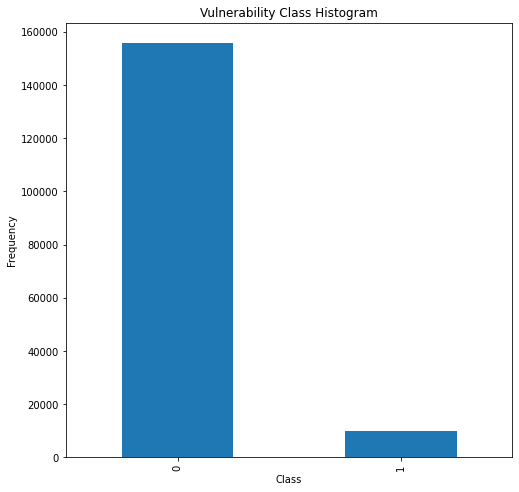

In [9]:
fig = plt.figure()
count_classes = pd.value_counts(data['CATEGORY'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Vulnerability Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
fig.set_size_inches(8, 8)
plt.show()
# fig.savefig('./figures/clean_train_unbalanced_distr.png', dpi=300) #, bbox_inches='tight'

### Dividing data into vulnerable and non-vulnerable

In [10]:
shuffled = data

n = shuffled[shuffled['CATEGORY'] == 0] # no vulnerabilities
s = shuffled[shuffled['CATEGORY'] == 1] # suicidal

### Plot two class unbalanced

E:\Softwares\anaconda\envs\my-rdkit-env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


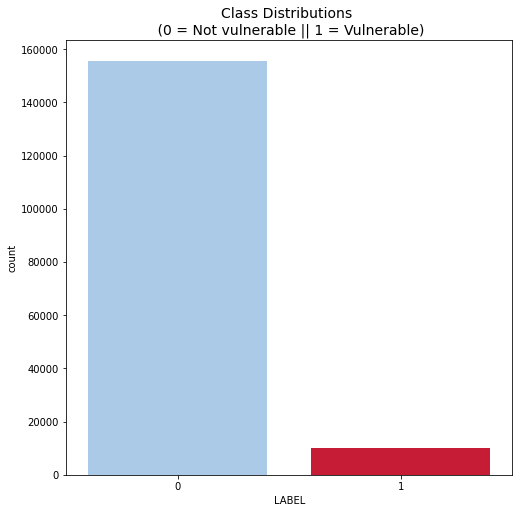

In [11]:
concated = pd.concat([n,s], ignore_index=True)

concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

concated.loc[concated['CATEGORY'] == 0, 'LABEL'] = 0
concated.loc[concated['CATEGORY'] != 0, 'LABEL'] = 1

import seaborn as sns
fig = plt.figure()
colors = ["#A1CAF1", "#E30022"]

sns.countplot('LABEL', data=concated, palette=colors)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)

### Dividing data into train, validation, and test

In [12]:
positives = pd.concat([s])
positives_shuf = positives.sample(frac=1, random_state=39, replace=False)
print(len(positives_shuf))

proportion_train = 0.64 #0.7 
proportion_val = 0.16 #0.1 
proportion_test = 0.2 #0.20

num_pos_train = round(len(positives_shuf) * proportion_train)
num_pos_val = round(len(positives_shuf) * proportion_val)

pos_train = positives_shuf.iloc[0:num_pos_train] 
pos_val = positives_shuf.iloc[num_pos_train:(num_pos_train+num_pos_val)]
pos_test = positives_shuf.iloc[(num_pos_train+num_pos_val):]

print(len(pos_train))
print(len(pos_val))
print(len(pos_test))

9985
6390
1598
1997


In [13]:
n_shuf = n.sample(frac=1, random_state=39, replace=False)
print(len(n_shuf))

num_neg_train = round(100000*0.64)

num_neg_val = round(((num_neg_train)/proportion_train)*proportion_val)
num_neg_test = round(((num_neg_train)/proportion_train)*proportion_test)

neg_train = n_shuf.iloc[0:num_neg_train]
neg_val = n_shuf.iloc[num_neg_train:(num_neg_train+num_neg_val)]
neg_test = n_shuf.iloc[(num_neg_train+num_neg_val):(num_neg_train+num_neg_val+num_neg_test)]


print(len(neg_train))
print(len(neg_val))
print(len(neg_test))

155667
64000
16000
20000


### Resampling samples

### Resampling samples

In [14]:
X_train, ytrain_labels = XandY(pos_train, neg_train)
X_val, yval_labels = XandY(pos_val, neg_val)
X_test, ytest_labels = XandY(pos_test, neg_test)

Found 142 unique tokens.
0    64000
1     6390
Name: LABEL, dtype: int64
Shape of X: (70390, 142)
Shape of y: (70390, 1)
Found 142 unique tokens.
0    16000
1     1598
Name: LABEL, dtype: int64
Shape of X: (17598, 142)
Shape of y: (17598, 1)
Found 142 unique tokens.
0    20000
1     1997
Name: LABEL, dtype: int64
Shape of X: (21997, 142)
Shape of y: (21997, 1)


In [40]:
X_train

array([[ 17,   7,  15, ...,  80, 105,  70],
       [  2,   5,   9, ...,  80,   1,  45],
       [ 23,  14,   3, ...,  85,  96,  62],
       ...,
       [  1,   3,  24, ..., 126,  98,  34],
       [  4,  13,   1, ...,  34,  63,  75],
       [  1,  12,   6, ...,  37,  31,  45]])

In [15]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", ytrain_labels.shape)
print("Number transactions X_val dataset: ", X_val.shape)
print("Number transactions y_val dataset: ", yval_labels.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", ytest_labels.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(ytrain_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(ytrain_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(yval_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(yval_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(ytest_labels==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytest_labels==0)))

Number transactions X_train dataset:  (70390, 142)
Number transactions y_train dataset:  (70390, 1)
Number transactions X_val dataset:  (17598, 142)
Number transactions y_val dataset:  (17598, 1)
Number transactions X_test dataset:  (21997, 142)
Number transactions y_test dataset:  (21997, 1)
Before OverSampling, counts of label '1': [6390]
Before OverSampling, counts of label '0': [64000]
Before OverSampling, counts of label '1': [1598]
Before OverSampling, counts of label '0': [16000]
Before OverSampling, counts of label '1': [1997]
Before OverSampling, counts of label '0': [20000] 



In [16]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=39)
X_train_res, y_train_res = sm.fit_sample(X_train, ytrain_labels.ravel())
X_val_res, y_val_res = sm.fit_sample(X_val, yval_labels.ravel())
X_test_res, y_test_res = sm.fit_sample(X_test, ytest_labels.ravel())

In [17]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))
print('After OverSampling, the shape of val_X: {}'.format(X_val_res.shape))
print('After OverSampling, the shape of val_y: {}'.format(y_val_res.shape))
print('After OverSampling, the shape of test_X: {}'.format(X_test_res.shape))
print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

print("After OverSampling, counts of train label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of train label '0': {}".format(sum(y_train_res==0)))
print("After OverSampling, counts of val label '1': {}".format(sum(y_val_res==1)))
print("After OverSampling, counts of val label '0': {}".format(sum(y_val_res==0)))
print("After OverSampling, counts of test label '1': {}".format(sum(y_test_res==1)))
print("After OverSampling, counts of test label '0': {}".format(sum(y_test_res==0)))

After OverSampling, the shape of train_X: (128000, 142)
After OverSampling, the shape of train_y: (128000,)
After OverSampling, the shape of val_X: (32000, 142)
After OverSampling, the shape of val_y: (32000,)
After OverSampling, the shape of test_X: (40000, 142)
After OverSampling, the shape of test_y: (40000,) 

After OverSampling, counts of train label '1': 64000
After OverSampling, counts of train label '0': 64000
After OverSampling, counts of val label '1': 16000
After OverSampling, counts of val label '0': 16000
After OverSampling, counts of test label '1': 20000
After OverSampling, counts of test label '0': 20000


### Plot two class balanced

In [18]:
entire_dataset = np.concatenate((y_train_res,y_val_res,y_test_res))

E:\Softwares\anaconda\envs\my-rdkit-env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


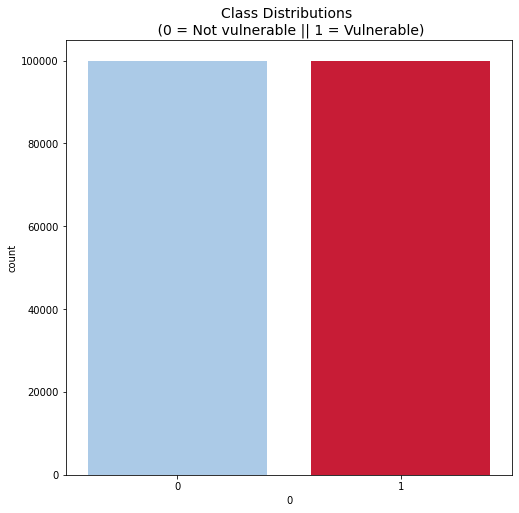

In [19]:
import seaborn as sns
fig = plt.figure()
colors = ["#A1CAF1", "#E30022"]

sns.countplot(0, data=pd.DataFrame(entire_dataset), palette=colors)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)

### Multiclass LSTM Model

In [17]:
epochs = 150
emb_dim = 128
batch_size = 256 


In [18]:
import keras
keras.backend.clear_session()

In [19]:
ytrainres_cat = to_categorical(y_train_res, num_classes=2)
yvalres_cat = to_categorical(y_val_res, num_classes=2)
ytestres_cat = to_categorical(y_test_res, num_classes=2)

print((X_train_res.shape, ytrainres_cat.shape, X_val_res.shape, yvalres_cat.shape, X_test_res.shape, ytestres_cat.shape))

((128000, 142), (128000, 2), (32000, 142), (32000, 2), (40000, 142), (40000, 2))


In [20]:
n_most_common_words = 1000
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X_train_res.shape[1]))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(64, dropout=0.6, recurrent_dropout=0.6))

model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

import time
start_time = time.time()

history = model.fit(X_train_res, ytrainres_cat, epochs=epochs, batch_size=batch_size, validation_split=0.0, validation_data=(X_val_res, yvalres_cat),callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])
end_time = time.time()
print('Time taken for training: ', end_time-start_time)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 142, 128)          128000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 142, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 177,538
Trainable params: 177,538
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
500/500 [==============================] - 217s 434ms/step - loss: 0.4162 - acc: 0.8109 - val_loss: 0.3115 - val_acc: 0.8738
Epoch 2/150
500/500 [==============================] - 204s 408ms/step - loss: 0.3148 - acc: 0.8687 - val_

Epoch 54/150
500/500 [==============================] - 212s 425ms/step - loss: 0.1426 - acc: 0.9501 - val_loss: 0.1992 - val_acc: 0.9202
Epoch 55/150
500/500 [==============================] - 215s 431ms/step - loss: 0.1424 - acc: 0.9503 - val_loss: 0.2263 - val_acc: 0.9150
Epoch 56/150
500/500 [==============================] - 205s 409ms/step - loss: 0.1414 - acc: 0.9511 - val_loss: 0.1887 - val_acc: 0.9185
Epoch 57/150
500/500 [==============================] - 197s 393ms/step - loss: 0.1407 - acc: 0.9509 - val_loss: 0.1713 - val_acc: 0.9444
Epoch 58/150
500/500 [==============================] - 216s 432ms/step - loss: 0.1407 - acc: 0.9511 - val_loss: 0.2374 - val_acc: 0.9158
Epoch 59/150
500/500 [==============================] - 216s 433ms/step - loss: 0.1410 - acc: 0.9508 - val_loss: 0.2030 - val_acc: 0.9205
Epoch 60/150
500/500 [==============================] - 211s 422ms/step - loss: 0.1395 - acc: 0.9517 - val_loss: 0.2357 - val_acc: 0.9089
Epoch 61/150
500/500 [============

### Test and evaluate model accuracy

In [21]:
accr = model.evaluate(X_test_res, ytestres_cat)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

1250/1250 [==============================] - 18s 15ms/step - loss: 0.1944 - acc: 0.9376
Test set
  Loss: 0.1944
  Accuracy: 0.9376


In [22]:
y_pred = model.predict_classes(X_test_res, batch_size=32, verbose=1)
ytest_true = y_test_res

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
1250/1250 [==============================] - 24s 19ms/step


In [24]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest_true, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

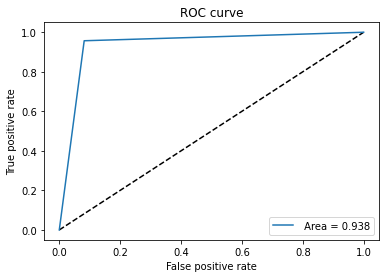

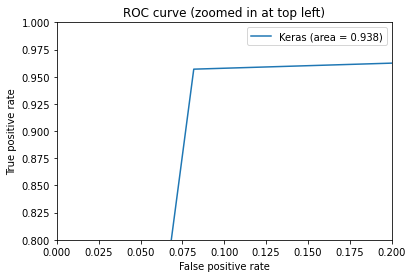

In [25]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=' Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [26]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(ytest_true, y_pred)
print('Average Precision Score: {:0.4f}\n'.format(average_precision))

Average Precision Score: 0.9031



In [28]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

Accuracy: 0.937575
Recall: 0.95695
Precision: 0.921251504211793
F1 score: 0.9387614960147149

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     20000
           1       0.92      0.96      0.94     20000

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000


 confusion matrix:
 [[18364  1636]
 [  861 19139]]


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

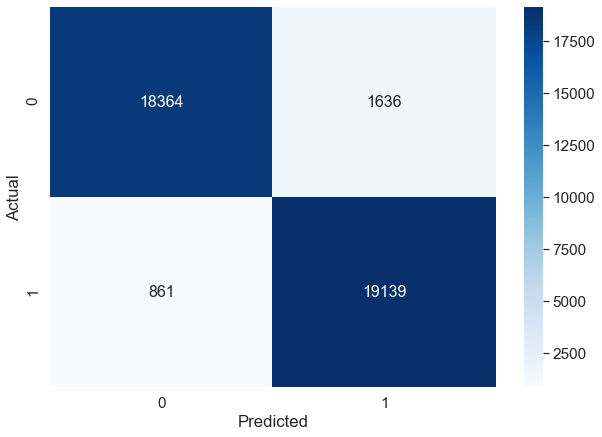

In [29]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(ytest_true, y_pred), columns=np.unique(ytest_true), index = np.unique(ytest_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt= 'g')# font size

# Plot Performance

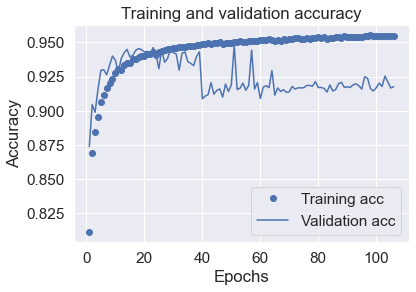

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# fig.savefig('clean_train_acc.png',dpi=300)

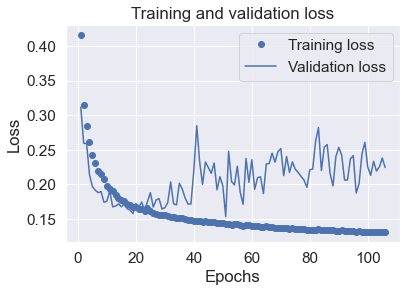

In [31]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# fig.savefig('clean_train_loss.png',dpi=300)